In [2]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from NFconstants import N_nod, beta, N_latent, a
from NFandist import get_O
from NFandist import get_diag

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)




False


In [4]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap=swap

    def g(self, z: torch.Tensor) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        z1, z2 = self.split(z,self.swap)
        t, s = self.theta(z1)
        x1, x2 = z1, z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        return torch.cat((x2, x1), dim=-1), log_det
    
    def f(self, x: torch.Tensor) -> torch.Tensor:
        """f : x -> z. The inverse of g."""
        x2, x1 = self.split(x,self.swap)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t 
        log_det = s.sum(-1) 
        return torch.cat((z1, z2), dim=-1), log_det

In [66]:
class CubicCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap=swap

    def g(self, z: torch.Tensor) -> torch.Tensor:
        z1, z2 = self.split(z,self.swap)
        t, s = self.theta(z1)
        x1 = z1 
        x2 = z2 + torch.exp(s-2) * (z2) ** 3 + t
        log_det = (torch.log(1+3 * torch.exp(s-2) * (z2) ** 2)).sum(-1) 
        return torch.cat((x2, x1), dim=-1), log_det
    

In [67]:
class D(nn.Linear):
    def __init__(self,n):
        super().__init__(n,1,bias=False)
        self.n=n
        self.d_ind=[(n+1)*k for k in range(n)]
    
    def anti_flatten(self):
        n=self.n
        D=torch.zeros((n**2)).to(device)
        D[self.d_ind]=self.weight.to(device)
        D=torch.reshape(D,(n,n)).to(device)
        return D        
            
    def log_abs_det(self):
        ABS=torch.abs(self.weight)
        l=torch.log(ABS)
        lad=torch.sum(l)
        return lad
    
    def forward(self,x):
        D=(self.anti_flatten()).to(x.device)
        return torch.matmul(x,D)
    
    def g(self,z):
        lad=self.log_abs_det()
        return self.forward(z),  lad * torch.ones((z.shape[0])).to(z.device)
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D
    

In [68]:
class L1(nn.Linear):
    def __init__(self,n):
        super().__init__(n*(n-1)//2,1,bias=False)
        self.n=n
        self.mask2d=torch.zeros((n*(n-1) // 2),dtype=int)
        for i in range(1,n):
            for j in range(i):
                self.mask2d[i*(i-1)//2+j]=i*n+j
        self.d_ind=[(n+1)*k for k in range(n)]
        self.ones=torch.ones((n)).to(device)
    
    def anti_flatten(self):
        n=self.n
        L=torch.zeros((n**2)).to(device)
        L[self.mask2d]=self.weight.to(device)
        L[self.d_ind]=self.ones
        L=torch.reshape(L,(n,n)).to(device)
        return L        
            
    def log_abs_det(self):
        return 0
    
    def forward(self,x):
        Lwt=torch.t(self.anti_flatten()).to(x.device)
        return torch.matmul(x,Lwt)
    
    def g(self,z):
        return self.forward(z), torch.zeros((z.shape[0])).to(z.device)
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D

In [69]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], conv_flows = [], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.conv_flows = conv_flows

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor) -> torch.Tensor:
        
        x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))
        
        #x=x*a    
        
        for flow in reversed(self.conv_flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward
        Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g.
        
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward\n        Maps observation x to latent variable z.\n        Additionally, computes the log determinant\n        of the Jacobian for this transformation.\n        Inveres of g.\n        \n        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)\n        for flow in self.flows:\n            z, log_abs_det = flow.f(z)\n            sum_log_abs_det += log_abs_det\n\n        return z, sum_log_abs_det\n'

In [70]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]
    

In [71]:
class Conv_NN(nn.Module):
    def __init__(
        self,
        out_dim,
        num_params,
        kernel_size=3
    ):
        super().__init__()
        self.layers = torch.nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=2, kernel_size=kernel_size,padding="same"), 
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),    
        nn.Conv1d(in_channels=2, out_channels=4, kernel_size=kernel_size,padding="same"), 
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),    
        nn.Conv1d(in_channels=4, out_channels=8, kernel_size=kernel_size,padding="same"),
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),
        nn.Conv1d(in_channels=8, out_channels=16, kernel_size=kernel_size,padding="same"),
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),
        nn.Conv1d(in_channels=16, out_channels=20, kernel_size=kernel_size,padding="same"),
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),
        nn.Conv1d(in_channels=20, out_channels=16, kernel_size=kernel_size,padding="same"),
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),
        nn.Conv1d(in_channels=16, out_channels=4, kernel_size=kernel_size,padding="same"),
        nn.LeakyReLU(),
        nn.LayerNorm(out_dim),        
        nn.Conv1d(in_channels=4, out_channels=1, kernel_size=kernel_size,padding="same"),
        nn.LeakyReLU(),    
        )
        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(out_dim, out_dim * num_params)
    
    def forward(self, x):
        x=x.unsqueeze(1)
        x=self.layers(x)
        x=x.squeeze(1)
        batch_params = self.dims(x).reshape(x.size(0),self.out_dim , -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]

In [72]:
def SplitFunc(x: torch.Tensor,swap: int) -> Tuple[torch.Tensor, torch.Tensor]:
    if swap==0:
        return x[:,::2], x[:,1::2]
    else: 
        return x[:,1::2], x[:,::2] 

In [73]:
I=torch.arange(N_nod)
i0=I[::4]
i1=I[1::4]
i2=I[2::4]
i3=I[3::4]
mask1=torch.cat((i0,i1))
mask2=torch.cat((i2,i3))

def pair_SplitFunc(x: torch.Tensor,swap: int) -> Tuple[torch.Tensor, torch.Tensor]:
    if swap==0:
        return x[:,mask1], x[:,mask2]
    else: 
        return x[:,mask2], x[:,mask1] 

In [134]:
print("start")
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 12,  #2 to 6
                hidden_dim = 2 * N_nod , #100-1024
                num_params = 2,
                p_drop=0.1,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    """
    flows.append(D(N_nod))
    
    for k in range(n_flows//2):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
        flows.append(L1(N_nod))
    
    #flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=0))
    #flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=1))
    
    for k in range(n_flows//2):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
    
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=0))
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=1))
    
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=0))
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=1))
    
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=0))
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=1))
    """
    flows.append(D(N_nod))    
    flows = nn.ModuleList(flows)
    return flows 

def configure_conv_flows(n_conv,kernel_size=3):
    conv_flows=[]
    for i in range(n_conv):
        conv_flows.append(AffineCouplingLayer(Conv_NN(N_nod//2,2,kernel_size),split=pair_SplitFunc,swap=i%2))
    conv_flows = nn.ModuleList(conv_flows)
    return conv_flows

print(normal_dist)

                  

start
Normal(loc: torch.Size([100]), scale: torch.Size([100]))


In [135]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [136]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
KL_osc=Oscillator.make_KL(Oscillator)
KL_rel001=Rel_Oscillator.make_KL(Rel_Oscillator,sigma=0.01)
KL_rel01=Rel_Oscillator.make_KL(Rel_Oscillator,sigma=0.1)
KL_rel1=Rel_Oscillator.make_KL(Rel_Oscillator,sigma=1)
KL_ur=Ur_Oscillator.make_KL(Ur_Oscillator)


In [138]:
from Data import train_loader

set_random_seed(42)

nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(24),conv_flows=configure_conv_flows(0,kernel_size=8),ort=True)
pipeline=Pipeline(model=nf, criterion=KL_ur, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.001,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs=50,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    accumulate_grad_batches=4
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")

/kernel/lib/python3.10/site-packages/wurlitzer.py:209: RuntimeWarning: Failed to set pipe buffer size
  warnings.warn("Failed to set pipe buffer size", RuntimeWarning)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 100   
1 | loss  | KL_with_S       | 0     
------------------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [23]:
from NFandist import calc_Z
import numpy as np
print(-np.log(calc_Z(N_nod,beta)))

4.997873416618259


In [99]:
from Data import train_loader

set_random_seed(42)
nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(24),conv_flows=configure_conv_flows(0,kernel_size=16),ort=True)
nf.load_state_dict(torch.load('model_weights1.pth'))
pipeline=Pipeline(model=nf,criterion=KL_ur,optimizer_class=torch.optim.LBFGS,optimizer_kwargs={"lr": 0.0001})

trainer = pl.Trainer(
    max_epochs=20,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=8
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights3.pth")

RuntimeError: Error(s) in loading state_dict for NormalizingFlow:
	Missing key(s) in state_dict: "flows.14.weight", "flows.16.weight", "flows.18.weight", "flows.20.weight", "flows.22.weight", "flows.23.theta.input.weight", "flows.23.theta.input.bias", "flows.23.theta.hidden.0.0.weight", "flows.23.theta.hidden.0.0.bias", "flows.23.theta.hidden.0.2.weight", "flows.23.theta.hidden.0.2.bias", "flows.23.theta.hidden.1.0.weight", "flows.23.theta.hidden.1.0.bias", "flows.23.theta.hidden.1.2.weight", "flows.23.theta.hidden.1.2.bias", "flows.23.theta.hidden.2.0.weight", "flows.23.theta.hidden.2.0.bias", "flows.23.theta.hidden.2.2.weight", "flows.23.theta.hidden.2.2.bias", "flows.23.theta.hidden.3.0.weight", "flows.23.theta.hidden.3.0.bias", "flows.23.theta.hidden.3.2.weight", "flows.23.theta.hidden.3.2.bias", "flows.23.theta.hidden.4.0.weight", "flows.23.theta.hidden.4.0.bias", "flows.23.theta.hidden.4.2.weight", "flows.23.theta.hidden.4.2.bias", "flows.23.theta.hidden.5.0.weight", "flows.23.theta.hidden.5.0.bias", "flows.23.theta.hidden.5.2.weight", "flows.23.theta.hidden.5.2.bias", "flows.23.theta.hidden.6.0.weight", "flows.23.theta.hidden.6.0.bias", "flows.23.theta.hidden.6.2.weight", "flows.23.theta.hidden.6.2.bias", "flows.23.theta.hidden.7.0.weight", "flows.23.theta.hidden.7.0.bias", "flows.23.theta.hidden.7.2.weight", "flows.23.theta.hidden.7.2.bias", "flows.23.theta.hidden.8.0.weight", "flows.23.theta.hidden.8.0.bias", "flows.23.theta.hidden.8.2.weight", "flows.23.theta.hidden.8.2.bias", "flows.23.theta.hidden.9.0.weight", "flows.23.theta.hidden.9.0.bias", "flows.23.theta.hidden.9.2.weight", "flows.23.theta.hidden.9.2.bias", "flows.23.theta.hidden.10.0.weight", "flows.23.theta.hidden.10.0.bias", "flows.23.theta.hidden.10.2.weight", "flows.23.theta.hidden.10.2.bias", "flows.23.theta.hidden.11.0.weight", "flows.23.theta.hidden.11.0.bias", "flows.23.theta.hidden.11.2.weight", "flows.23.theta.hidden.11.2.bias", "flows.23.theta.dims.weight", "flows.23.theta.dims.bias", "flows.24.weight", "flows.25.theta.input.weight", "flows.25.theta.input.bias", "flows.25.theta.hidden.0.0.weight", "flows.25.theta.hidden.0.0.bias", "flows.25.theta.hidden.0.2.weight", "flows.25.theta.hidden.0.2.bias", "flows.25.theta.hidden.1.0.weight", "flows.25.theta.hidden.1.0.bias", "flows.25.theta.hidden.1.2.weight", "flows.25.theta.hidden.1.2.bias", "flows.25.theta.hidden.2.0.weight", "flows.25.theta.hidden.2.0.bias", "flows.25.theta.hidden.2.2.weight", "flows.25.theta.hidden.2.2.bias", "flows.25.theta.hidden.3.0.weight", "flows.25.theta.hidden.3.0.bias", "flows.25.theta.hidden.3.2.weight", "flows.25.theta.hidden.3.2.bias", "flows.25.theta.hidden.4.0.weight", "flows.25.theta.hidden.4.0.bias", "flows.25.theta.hidden.4.2.weight", "flows.25.theta.hidden.4.2.bias", "flows.25.theta.hidden.5.0.weight", "flows.25.theta.hidden.5.0.bias", "flows.25.theta.hidden.5.2.weight", "flows.25.theta.hidden.5.2.bias", "flows.25.theta.hidden.6.0.weight", "flows.25.theta.hidden.6.0.bias", "flows.25.theta.hidden.6.2.weight", "flows.25.theta.hidden.6.2.bias", "flows.25.theta.hidden.7.0.weight", "flows.25.theta.hidden.7.0.bias", "flows.25.theta.hidden.7.2.weight", "flows.25.theta.hidden.7.2.bias", "flows.25.theta.hidden.8.0.weight", "flows.25.theta.hidden.8.0.bias", "flows.25.theta.hidden.8.2.weight", "flows.25.theta.hidden.8.2.bias", "flows.25.theta.hidden.9.0.weight", "flows.25.theta.hidden.9.0.bias", "flows.25.theta.hidden.9.2.weight", "flows.25.theta.hidden.9.2.bias", "flows.25.theta.hidden.10.0.weight", "flows.25.theta.hidden.10.0.bias", "flows.25.theta.hidden.10.2.weight", "flows.25.theta.hidden.10.2.bias", "flows.25.theta.hidden.11.0.weight", "flows.25.theta.hidden.11.0.bias", "flows.25.theta.hidden.11.2.weight", "flows.25.theta.hidden.11.2.bias", "flows.25.theta.dims.weight", "flows.25.theta.dims.bias", "flows.26.theta.input.weight", "flows.26.theta.input.bias", "flows.26.theta.hidden.0.0.weight", "flows.26.theta.hidden.0.0.bias", "flows.26.theta.hidden.0.2.weight", "flows.26.theta.hidden.0.2.bias", "flows.26.theta.hidden.1.0.weight", "flows.26.theta.hidden.1.0.bias", "flows.26.theta.hidden.1.2.weight", "flows.26.theta.hidden.1.2.bias", "flows.26.theta.hidden.2.0.weight", "flows.26.theta.hidden.2.0.bias", "flows.26.theta.hidden.2.2.weight", "flows.26.theta.hidden.2.2.bias", "flows.26.theta.hidden.3.0.weight", "flows.26.theta.hidden.3.0.bias", "flows.26.theta.hidden.3.2.weight", "flows.26.theta.hidden.3.2.bias", "flows.26.theta.hidden.4.0.weight", "flows.26.theta.hidden.4.0.bias", "flows.26.theta.hidden.4.2.weight", "flows.26.theta.hidden.4.2.bias", "flows.26.theta.hidden.5.0.weight", "flows.26.theta.hidden.5.0.bias", "flows.26.theta.hidden.5.2.weight", "flows.26.theta.hidden.5.2.bias", "flows.26.theta.hidden.6.0.weight", "flows.26.theta.hidden.6.0.bias", "flows.26.theta.hidden.6.2.weight", "flows.26.theta.hidden.6.2.bias", "flows.26.theta.hidden.7.0.weight", "flows.26.theta.hidden.7.0.bias", "flows.26.theta.hidden.7.2.weight", "flows.26.theta.hidden.7.2.bias", "flows.26.theta.hidden.8.0.weight", "flows.26.theta.hidden.8.0.bias", "flows.26.theta.hidden.8.2.weight", "flows.26.theta.hidden.8.2.bias", "flows.26.theta.hidden.9.0.weight", "flows.26.theta.hidden.9.0.bias", "flows.26.theta.hidden.9.2.weight", "flows.26.theta.hidden.9.2.bias", "flows.26.theta.hidden.10.0.weight", "flows.26.theta.hidden.10.0.bias", "flows.26.theta.hidden.10.2.weight", "flows.26.theta.hidden.10.2.bias", "flows.26.theta.hidden.11.0.weight", "flows.26.theta.hidden.11.0.bias", "flows.26.theta.hidden.11.2.weight", "flows.26.theta.hidden.11.2.bias", "flows.26.theta.dims.weight", "flows.26.theta.dims.bias", "flows.27.theta.input.weight", "flows.27.theta.input.bias", "flows.27.theta.hidden.0.0.weight", "flows.27.theta.hidden.0.0.bias", "flows.27.theta.hidden.0.2.weight", "flows.27.theta.hidden.0.2.bias", "flows.27.theta.hidden.1.0.weight", "flows.27.theta.hidden.1.0.bias", "flows.27.theta.hidden.1.2.weight", "flows.27.theta.hidden.1.2.bias", "flows.27.theta.hidden.2.0.weight", "flows.27.theta.hidden.2.0.bias", "flows.27.theta.hidden.2.2.weight", "flows.27.theta.hidden.2.2.bias", "flows.27.theta.hidden.3.0.weight", "flows.27.theta.hidden.3.0.bias", "flows.27.theta.hidden.3.2.weight", "flows.27.theta.hidden.3.2.bias", "flows.27.theta.hidden.4.0.weight", "flows.27.theta.hidden.4.0.bias", "flows.27.theta.hidden.4.2.weight", "flows.27.theta.hidden.4.2.bias", "flows.27.theta.hidden.5.0.weight", "flows.27.theta.hidden.5.0.bias", "flows.27.theta.hidden.5.2.weight", "flows.27.theta.hidden.5.2.bias", "flows.27.theta.hidden.6.0.weight", "flows.27.theta.hidden.6.0.bias", "flows.27.theta.hidden.6.2.weight", "flows.27.theta.hidden.6.2.bias", "flows.27.theta.hidden.7.0.weight", "flows.27.theta.hidden.7.0.bias", "flows.27.theta.hidden.7.2.weight", "flows.27.theta.hidden.7.2.bias", "flows.27.theta.hidden.8.0.weight", "flows.27.theta.hidden.8.0.bias", "flows.27.theta.hidden.8.2.weight", "flows.27.theta.hidden.8.2.bias", "flows.27.theta.hidden.9.0.weight", "flows.27.theta.hidden.9.0.bias", "flows.27.theta.hidden.9.2.weight", "flows.27.theta.hidden.9.2.bias", "flows.27.theta.hidden.10.0.weight", "flows.27.theta.hidden.10.0.bias", "flows.27.theta.hidden.10.2.weight", "flows.27.theta.hidden.10.2.bias", "flows.27.theta.hidden.11.0.weight", "flows.27.theta.hidden.11.0.bias", "flows.27.theta.hidden.11.2.weight", "flows.27.theta.hidden.11.2.bias", "flows.27.theta.dims.weight", "flows.27.theta.dims.bias", "flows.28.theta.input.weight", "flows.28.theta.input.bias", "flows.28.theta.hidden.0.0.weight", "flows.28.theta.hidden.0.0.bias", "flows.28.theta.hidden.0.2.weight", "flows.28.theta.hidden.0.2.bias", "flows.28.theta.hidden.1.0.weight", "flows.28.theta.hidden.1.0.bias", "flows.28.theta.hidden.1.2.weight", "flows.28.theta.hidden.1.2.bias", "flows.28.theta.hidden.2.0.weight", "flows.28.theta.hidden.2.0.bias", "flows.28.theta.hidden.2.2.weight", "flows.28.theta.hidden.2.2.bias", "flows.28.theta.hidden.3.0.weight", "flows.28.theta.hidden.3.0.bias", "flows.28.theta.hidden.3.2.weight", "flows.28.theta.hidden.3.2.bias", "flows.28.theta.hidden.4.0.weight", "flows.28.theta.hidden.4.0.bias", "flows.28.theta.hidden.4.2.weight", "flows.28.theta.hidden.4.2.bias", "flows.28.theta.hidden.5.0.weight", "flows.28.theta.hidden.5.0.bias", "flows.28.theta.hidden.5.2.weight", "flows.28.theta.hidden.5.2.bias", "flows.28.theta.hidden.6.0.weight", "flows.28.theta.hidden.6.0.bias", "flows.28.theta.hidden.6.2.weight", "flows.28.theta.hidden.6.2.bias", "flows.28.theta.hidden.7.0.weight", "flows.28.theta.hidden.7.0.bias", "flows.28.theta.hidden.7.2.weight", "flows.28.theta.hidden.7.2.bias", "flows.28.theta.hidden.8.0.weight", "flows.28.theta.hidden.8.0.bias", "flows.28.theta.hidden.8.2.weight", "flows.28.theta.hidden.8.2.bias", "flows.28.theta.hidden.9.0.weight", "flows.28.theta.hidden.9.0.bias", "flows.28.theta.hidden.9.2.weight", "flows.28.theta.hidden.9.2.bias", "flows.28.theta.hidden.10.0.weight", "flows.28.theta.hidden.10.0.bias", "flows.28.theta.hidden.10.2.weight", "flows.28.theta.hidden.10.2.bias", "flows.28.theta.hidden.11.0.weight", "flows.28.theta.hidden.11.0.bias", "flows.28.theta.hidden.11.2.weight", "flows.28.theta.hidden.11.2.bias", "flows.28.theta.dims.weight", "flows.28.theta.dims.bias", "flows.29.theta.input.weight", "flows.29.theta.input.bias", "flows.29.theta.hidden.0.0.weight", "flows.29.theta.hidden.0.0.bias", "flows.29.theta.hidden.0.2.weight", "flows.29.theta.hidden.0.2.bias", "flows.29.theta.hidden.1.0.weight", "flows.29.theta.hidden.1.0.bias", "flows.29.theta.hidden.1.2.weight", "flows.29.theta.hidden.1.2.bias", "flows.29.theta.hidden.2.0.weight", "flows.29.theta.hidden.2.0.bias", "flows.29.theta.hidden.2.2.weight", "flows.29.theta.hidden.2.2.bias", "flows.29.theta.hidden.3.0.weight", "flows.29.theta.hidden.3.0.bias", "flows.29.theta.hidden.3.2.weight", "flows.29.theta.hidden.3.2.bias", "flows.29.theta.hidden.4.0.weight", "flows.29.theta.hidden.4.0.bias", "flows.29.theta.hidden.4.2.weight", "flows.29.theta.hidden.4.2.bias", "flows.29.theta.hidden.5.0.weight", "flows.29.theta.hidden.5.0.bias", "flows.29.theta.hidden.5.2.weight", "flows.29.theta.hidden.5.2.bias", "flows.29.theta.hidden.6.0.weight", "flows.29.theta.hidden.6.0.bias", "flows.29.theta.hidden.6.2.weight", "flows.29.theta.hidden.6.2.bias", "flows.29.theta.hidden.7.0.weight", "flows.29.theta.hidden.7.0.bias", "flows.29.theta.hidden.7.2.weight", "flows.29.theta.hidden.7.2.bias", "flows.29.theta.hidden.8.0.weight", "flows.29.theta.hidden.8.0.bias", "flows.29.theta.hidden.8.2.weight", "flows.29.theta.hidden.8.2.bias", "flows.29.theta.hidden.9.0.weight", "flows.29.theta.hidden.9.0.bias", "flows.29.theta.hidden.9.2.weight", "flows.29.theta.hidden.9.2.bias", "flows.29.theta.hidden.10.0.weight", "flows.29.theta.hidden.10.0.bias", "flows.29.theta.hidden.10.2.weight", "flows.29.theta.hidden.10.2.bias", "flows.29.theta.hidden.11.0.weight", "flows.29.theta.hidden.11.0.bias", "flows.29.theta.hidden.11.2.weight", "flows.29.theta.hidden.11.2.bias", "flows.29.theta.dims.weight", "flows.29.theta.dims.bias", "flows.30.theta.input.weight", "flows.30.theta.input.bias", "flows.30.theta.hidden.0.0.weight", "flows.30.theta.hidden.0.0.bias", "flows.30.theta.hidden.0.2.weight", "flows.30.theta.hidden.0.2.bias", "flows.30.theta.hidden.1.0.weight", "flows.30.theta.hidden.1.0.bias", "flows.30.theta.hidden.1.2.weight", "flows.30.theta.hidden.1.2.bias", "flows.30.theta.hidden.2.0.weight", "flows.30.theta.hidden.2.0.bias", "flows.30.theta.hidden.2.2.weight", "flows.30.theta.hidden.2.2.bias", "flows.30.theta.hidden.3.0.weight", "flows.30.theta.hidden.3.0.bias", "flows.30.theta.hidden.3.2.weight", "flows.30.theta.hidden.3.2.bias", "flows.30.theta.hidden.4.0.weight", "flows.30.theta.hidden.4.0.bias", "flows.30.theta.hidden.4.2.weight", "flows.30.theta.hidden.4.2.bias", "flows.30.theta.hidden.5.0.weight", "flows.30.theta.hidden.5.0.bias", "flows.30.theta.hidden.5.2.weight", "flows.30.theta.hidden.5.2.bias", "flows.30.theta.hidden.6.0.weight", "flows.30.theta.hidden.6.0.bias", "flows.30.theta.hidden.6.2.weight", "flows.30.theta.hidden.6.2.bias", "flows.30.theta.hidden.7.0.weight", "flows.30.theta.hidden.7.0.bias", "flows.30.theta.hidden.7.2.weight", "flows.30.theta.hidden.7.2.bias", "flows.30.theta.hidden.8.0.weight", "flows.30.theta.hidden.8.0.bias", "flows.30.theta.hidden.8.2.weight", "flows.30.theta.hidden.8.2.bias", "flows.30.theta.hidden.9.0.weight", "flows.30.theta.hidden.9.0.bias", "flows.30.theta.hidden.9.2.weight", "flows.30.theta.hidden.9.2.bias", "flows.30.theta.hidden.10.0.weight", "flows.30.theta.hidden.10.0.bias", "flows.30.theta.hidden.10.2.weight", "flows.30.theta.hidden.10.2.bias", "flows.30.theta.hidden.11.0.weight", "flows.30.theta.hidden.11.0.bias", "flows.30.theta.hidden.11.2.weight", "flows.30.theta.hidden.11.2.bias", "flows.30.theta.dims.weight", "flows.30.theta.dims.bias", "flows.31.theta.input.weight", "flows.31.theta.input.bias", "flows.31.theta.hidden.0.0.weight", "flows.31.theta.hidden.0.0.bias", "flows.31.theta.hidden.0.2.weight", "flows.31.theta.hidden.0.2.bias", "flows.31.theta.hidden.1.0.weight", "flows.31.theta.hidden.1.0.bias", "flows.31.theta.hidden.1.2.weight", "flows.31.theta.hidden.1.2.bias", "flows.31.theta.hidden.2.0.weight", "flows.31.theta.hidden.2.0.bias", "flows.31.theta.hidden.2.2.weight", "flows.31.theta.hidden.2.2.bias", "flows.31.theta.hidden.3.0.weight", "flows.31.theta.hidden.3.0.bias", "flows.31.theta.hidden.3.2.weight", "flows.31.theta.hidden.3.2.bias", "flows.31.theta.hidden.4.0.weight", "flows.31.theta.hidden.4.0.bias", "flows.31.theta.hidden.4.2.weight", "flows.31.theta.hidden.4.2.bias", "flows.31.theta.hidden.5.0.weight", "flows.31.theta.hidden.5.0.bias", "flows.31.theta.hidden.5.2.weight", "flows.31.theta.hidden.5.2.bias", "flows.31.theta.hidden.6.0.weight", "flows.31.theta.hidden.6.0.bias", "flows.31.theta.hidden.6.2.weight", "flows.31.theta.hidden.6.2.bias", "flows.31.theta.hidden.7.0.weight", "flows.31.theta.hidden.7.0.bias", "flows.31.theta.hidden.7.2.weight", "flows.31.theta.hidden.7.2.bias", "flows.31.theta.hidden.8.0.weight", "flows.31.theta.hidden.8.0.bias", "flows.31.theta.hidden.8.2.weight", "flows.31.theta.hidden.8.2.bias", "flows.31.theta.hidden.9.0.weight", "flows.31.theta.hidden.9.0.bias", "flows.31.theta.hidden.9.2.weight", "flows.31.theta.hidden.9.2.bias", "flows.31.theta.hidden.10.0.weight", "flows.31.theta.hidden.10.0.bias", "flows.31.theta.hidden.10.2.weight", "flows.31.theta.hidden.10.2.bias", "flows.31.theta.hidden.11.0.weight", "flows.31.theta.hidden.11.0.bias", "flows.31.theta.hidden.11.2.weight", "flows.31.theta.hidden.11.2.bias", "flows.31.theta.dims.weight", "flows.31.theta.dims.bias", "flows.32.theta.input.weight", "flows.32.theta.input.bias", "flows.32.theta.hidden.0.0.weight", "flows.32.theta.hidden.0.0.bias", "flows.32.theta.hidden.0.2.weight", "flows.32.theta.hidden.0.2.bias", "flows.32.theta.hidden.1.0.weight", "flows.32.theta.hidden.1.0.bias", "flows.32.theta.hidden.1.2.weight", "flows.32.theta.hidden.1.2.bias", "flows.32.theta.hidden.2.0.weight", "flows.32.theta.hidden.2.0.bias", "flows.32.theta.hidden.2.2.weight", "flows.32.theta.hidden.2.2.bias", "flows.32.theta.hidden.3.0.weight", "flows.32.theta.hidden.3.0.bias", "flows.32.theta.hidden.3.2.weight", "flows.32.theta.hidden.3.2.bias", "flows.32.theta.hidden.4.0.weight", "flows.32.theta.hidden.4.0.bias", "flows.32.theta.hidden.4.2.weight", "flows.32.theta.hidden.4.2.bias", "flows.32.theta.hidden.5.0.weight", "flows.32.theta.hidden.5.0.bias", "flows.32.theta.hidden.5.2.weight", "flows.32.theta.hidden.5.2.bias", "flows.32.theta.hidden.6.0.weight", "flows.32.theta.hidden.6.0.bias", "flows.32.theta.hidden.6.2.weight", "flows.32.theta.hidden.6.2.bias", "flows.32.theta.hidden.7.0.weight", "flows.32.theta.hidden.7.0.bias", "flows.32.theta.hidden.7.2.weight", "flows.32.theta.hidden.7.2.bias", "flows.32.theta.hidden.8.0.weight", "flows.32.theta.hidden.8.0.bias", "flows.32.theta.hidden.8.2.weight", "flows.32.theta.hidden.8.2.bias", "flows.32.theta.hidden.9.0.weight", "flows.32.theta.hidden.9.0.bias", "flows.32.theta.hidden.9.2.weight", "flows.32.theta.hidden.9.2.bias", "flows.32.theta.hidden.10.0.weight", "flows.32.theta.hidden.10.0.bias", "flows.32.theta.hidden.10.2.weight", "flows.32.theta.hidden.10.2.bias", "flows.32.theta.hidden.11.0.weight", "flows.32.theta.hidden.11.0.bias", "flows.32.theta.hidden.11.2.weight", "flows.32.theta.hidden.11.2.bias", "flows.32.theta.dims.weight", "flows.32.theta.dims.bias", "flows.33.theta.input.weight", "flows.33.theta.input.bias", "flows.33.theta.hidden.0.0.weight", "flows.33.theta.hidden.0.0.bias", "flows.33.theta.hidden.0.2.weight", "flows.33.theta.hidden.0.2.bias", "flows.33.theta.hidden.1.0.weight", "flows.33.theta.hidden.1.0.bias", "flows.33.theta.hidden.1.2.weight", "flows.33.theta.hidden.1.2.bias", "flows.33.theta.hidden.2.0.weight", "flows.33.theta.hidden.2.0.bias", "flows.33.theta.hidden.2.2.weight", "flows.33.theta.hidden.2.2.bias", "flows.33.theta.hidden.3.0.weight", "flows.33.theta.hidden.3.0.bias", "flows.33.theta.hidden.3.2.weight", "flows.33.theta.hidden.3.2.bias", "flows.33.theta.hidden.4.0.weight", "flows.33.theta.hidden.4.0.bias", "flows.33.theta.hidden.4.2.weight", "flows.33.theta.hidden.4.2.bias", "flows.33.theta.hidden.5.0.weight", "flows.33.theta.hidden.5.0.bias", "flows.33.theta.hidden.5.2.weight", "flows.33.theta.hidden.5.2.bias", "flows.33.theta.hidden.6.0.weight", "flows.33.theta.hidden.6.0.bias", "flows.33.theta.hidden.6.2.weight", "flows.33.theta.hidden.6.2.bias", "flows.33.theta.hidden.7.0.weight", "flows.33.theta.hidden.7.0.bias", "flows.33.theta.hidden.7.2.weight", "flows.33.theta.hidden.7.2.bias", "flows.33.theta.hidden.8.0.weight", "flows.33.theta.hidden.8.0.bias", "flows.33.theta.hidden.8.2.weight", "flows.33.theta.hidden.8.2.bias", "flows.33.theta.hidden.9.0.weight", "flows.33.theta.hidden.9.0.bias", "flows.33.theta.hidden.9.2.weight", "flows.33.theta.hidden.9.2.bias", "flows.33.theta.hidden.10.0.weight", "flows.33.theta.hidden.10.0.bias", "flows.33.theta.hidden.10.2.weight", "flows.33.theta.hidden.10.2.bias", "flows.33.theta.hidden.11.0.weight", "flows.33.theta.hidden.11.0.bias", "flows.33.theta.hidden.11.2.weight", "flows.33.theta.hidden.11.2.bias", "flows.33.theta.dims.weight", "flows.33.theta.dims.bias", "flows.34.theta.input.weight", "flows.34.theta.input.bias", "flows.34.theta.hidden.0.0.weight", "flows.34.theta.hidden.0.0.bias", "flows.34.theta.hidden.0.2.weight", "flows.34.theta.hidden.0.2.bias", "flows.34.theta.hidden.1.0.weight", "flows.34.theta.hidden.1.0.bias", "flows.34.theta.hidden.1.2.weight", "flows.34.theta.hidden.1.2.bias", "flows.34.theta.hidden.2.0.weight", "flows.34.theta.hidden.2.0.bias", "flows.34.theta.hidden.2.2.weight", "flows.34.theta.hidden.2.2.bias", "flows.34.theta.hidden.3.0.weight", "flows.34.theta.hidden.3.0.bias", "flows.34.theta.hidden.3.2.weight", "flows.34.theta.hidden.3.2.bias", "flows.34.theta.hidden.4.0.weight", "flows.34.theta.hidden.4.0.bias", "flows.34.theta.hidden.4.2.weight", "flows.34.theta.hidden.4.2.bias", "flows.34.theta.hidden.5.0.weight", "flows.34.theta.hidden.5.0.bias", "flows.34.theta.hidden.5.2.weight", "flows.34.theta.hidden.5.2.bias", "flows.34.theta.hidden.6.0.weight", "flows.34.theta.hidden.6.0.bias", "flows.34.theta.hidden.6.2.weight", "flows.34.theta.hidden.6.2.bias", "flows.34.theta.hidden.7.0.weight", "flows.34.theta.hidden.7.0.bias", "flows.34.theta.hidden.7.2.weight", "flows.34.theta.hidden.7.2.bias", "flows.34.theta.hidden.8.0.weight", "flows.34.theta.hidden.8.0.bias", "flows.34.theta.hidden.8.2.weight", "flows.34.theta.hidden.8.2.bias", "flows.34.theta.hidden.9.0.weight", "flows.34.theta.hidden.9.0.bias", "flows.34.theta.hidden.9.2.weight", "flows.34.theta.hidden.9.2.bias", "flows.34.theta.hidden.10.0.weight", "flows.34.theta.hidden.10.0.bias", "flows.34.theta.hidden.10.2.weight", "flows.34.theta.hidden.10.2.bias", "flows.34.theta.hidden.11.0.weight", "flows.34.theta.hidden.11.0.bias", "flows.34.theta.hidden.11.2.weight", "flows.34.theta.hidden.11.2.bias", "flows.34.theta.dims.weight", "flows.34.theta.dims.bias", "flows.35.theta.input.weight", "flows.35.theta.input.bias", "flows.35.theta.hidden.0.0.weight", "flows.35.theta.hidden.0.0.bias", "flows.35.theta.hidden.0.2.weight", "flows.35.theta.hidden.0.2.bias", "flows.35.theta.hidden.1.0.weight", "flows.35.theta.hidden.1.0.bias", "flows.35.theta.hidden.1.2.weight", "flows.35.theta.hidden.1.2.bias", "flows.35.theta.hidden.2.0.weight", "flows.35.theta.hidden.2.0.bias", "flows.35.theta.hidden.2.2.weight", "flows.35.theta.hidden.2.2.bias", "flows.35.theta.hidden.3.0.weight", "flows.35.theta.hidden.3.0.bias", "flows.35.theta.hidden.3.2.weight", "flows.35.theta.hidden.3.2.bias", "flows.35.theta.hidden.4.0.weight", "flows.35.theta.hidden.4.0.bias", "flows.35.theta.hidden.4.2.weight", "flows.35.theta.hidden.4.2.bias", "flows.35.theta.hidden.5.0.weight", "flows.35.theta.hidden.5.0.bias", "flows.35.theta.hidden.5.2.weight", "flows.35.theta.hidden.5.2.bias", "flows.35.theta.hidden.6.0.weight", "flows.35.theta.hidden.6.0.bias", "flows.35.theta.hidden.6.2.weight", "flows.35.theta.hidden.6.2.bias", "flows.35.theta.hidden.7.0.weight", "flows.35.theta.hidden.7.0.bias", "flows.35.theta.hidden.7.2.weight", "flows.35.theta.hidden.7.2.bias", "flows.35.theta.hidden.8.0.weight", "flows.35.theta.hidden.8.0.bias", "flows.35.theta.hidden.8.2.weight", "flows.35.theta.hidden.8.2.bias", "flows.35.theta.hidden.9.0.weight", "flows.35.theta.hidden.9.0.bias", "flows.35.theta.hidden.9.2.weight", "flows.35.theta.hidden.9.2.bias", "flows.35.theta.hidden.10.0.weight", "flows.35.theta.hidden.10.0.bias", "flows.35.theta.hidden.10.2.weight", "flows.35.theta.hidden.10.2.bias", "flows.35.theta.hidden.11.0.weight", "flows.35.theta.hidden.11.0.bias", "flows.35.theta.hidden.11.2.weight", "flows.35.theta.hidden.11.2.bias", "flows.35.theta.dims.weight", "flows.35.theta.dims.bias", "flows.36.theta.input.weight", "flows.36.theta.input.bias", "flows.36.theta.hidden.0.0.weight", "flows.36.theta.hidden.0.0.bias", "flows.36.theta.hidden.0.2.weight", "flows.36.theta.hidden.0.2.bias", "flows.36.theta.hidden.1.0.weight", "flows.36.theta.hidden.1.0.bias", "flows.36.theta.hidden.1.2.weight", "flows.36.theta.hidden.1.2.bias", "flows.36.theta.hidden.2.0.weight", "flows.36.theta.hidden.2.0.bias", "flows.36.theta.hidden.2.2.weight", "flows.36.theta.hidden.2.2.bias", "flows.36.theta.hidden.3.0.weight", "flows.36.theta.hidden.3.0.bias", "flows.36.theta.hidden.3.2.weight", "flows.36.theta.hidden.3.2.bias", "flows.36.theta.hidden.4.0.weight", "flows.36.theta.hidden.4.0.bias", "flows.36.theta.hidden.4.2.weight", "flows.36.theta.hidden.4.2.bias", "flows.36.theta.hidden.5.0.weight", "flows.36.theta.hidden.5.0.bias", "flows.36.theta.hidden.5.2.weight", "flows.36.theta.hidden.5.2.bias", "flows.36.theta.hidden.6.0.weight", "flows.36.theta.hidden.6.0.bias", "flows.36.theta.hidden.6.2.weight", "flows.36.theta.hidden.6.2.bias", "flows.36.theta.hidden.7.0.weight", "flows.36.theta.hidden.7.0.bias", "flows.36.theta.hidden.7.2.weight", "flows.36.theta.hidden.7.2.bias", "flows.36.theta.hidden.8.0.weight", "flows.36.theta.hidden.8.0.bias", "flows.36.theta.hidden.8.2.weight", "flows.36.theta.hidden.8.2.bias", "flows.36.theta.hidden.9.0.weight", "flows.36.theta.hidden.9.0.bias", "flows.36.theta.hidden.9.2.weight", "flows.36.theta.hidden.9.2.bias", "flows.36.theta.hidden.10.0.weight", "flows.36.theta.hidden.10.0.bias", "flows.36.theta.hidden.10.2.weight", "flows.36.theta.hidden.10.2.bias", "flows.36.theta.hidden.11.0.weight", "flows.36.theta.hidden.11.0.bias", "flows.36.theta.hidden.11.2.weight", "flows.36.theta.hidden.11.2.bias", "flows.36.theta.dims.weight", "flows.36.theta.dims.bias", "flows.37.theta.input.weight", "flows.37.theta.input.bias", "flows.37.theta.hidden.0.0.weight", "flows.37.theta.hidden.0.0.bias", "flows.37.theta.hidden.0.2.weight", "flows.37.theta.hidden.0.2.bias", "flows.37.theta.hidden.1.0.weight", "flows.37.theta.hidden.1.0.bias", "flows.37.theta.hidden.1.2.weight", "flows.37.theta.hidden.1.2.bias", "flows.37.theta.hidden.2.0.weight", "flows.37.theta.hidden.2.0.bias", "flows.37.theta.hidden.2.2.weight", "flows.37.theta.hidden.2.2.bias", "flows.37.theta.hidden.3.0.weight", "flows.37.theta.hidden.3.0.bias", "flows.37.theta.hidden.3.2.weight", "flows.37.theta.hidden.3.2.bias", "flows.37.theta.hidden.4.0.weight", "flows.37.theta.hidden.4.0.bias", "flows.37.theta.hidden.4.2.weight", "flows.37.theta.hidden.4.2.bias", "flows.37.theta.hidden.5.0.weight", "flows.37.theta.hidden.5.0.bias", "flows.37.theta.hidden.5.2.weight", "flows.37.theta.hidden.5.2.bias", "flows.37.theta.hidden.6.0.weight", "flows.37.theta.hidden.6.0.bias", "flows.37.theta.hidden.6.2.weight", "flows.37.theta.hidden.6.2.bias", "flows.37.theta.hidden.7.0.weight", "flows.37.theta.hidden.7.0.bias", "flows.37.theta.hidden.7.2.weight", "flows.37.theta.hidden.7.2.bias", "flows.37.theta.hidden.8.0.weight", "flows.37.theta.hidden.8.0.bias", "flows.37.theta.hidden.8.2.weight", "flows.37.theta.hidden.8.2.bias", "flows.37.theta.hidden.9.0.weight", "flows.37.theta.hidden.9.0.bias", "flows.37.theta.hidden.9.2.weight", "flows.37.theta.hidden.9.2.bias", "flows.37.theta.hidden.10.0.weight", "flows.37.theta.hidden.10.0.bias", "flows.37.theta.hidden.10.2.weight", "flows.37.theta.hidden.10.2.bias", "flows.37.theta.hidden.11.0.weight", "flows.37.theta.hidden.11.0.bias", "flows.37.theta.hidden.11.2.weight", "flows.37.theta.hidden.11.2.bias", "flows.37.theta.dims.weight", "flows.37.theta.dims.bias", "flows.38.theta.input.weight", "flows.38.theta.input.bias", "flows.38.theta.hidden.0.0.weight", "flows.38.theta.hidden.0.0.bias", "flows.38.theta.hidden.0.2.weight", "flows.38.theta.hidden.0.2.bias", "flows.38.theta.hidden.1.0.weight", "flows.38.theta.hidden.1.0.bias", "flows.38.theta.hidden.1.2.weight", "flows.38.theta.hidden.1.2.bias", "flows.38.theta.hidden.2.0.weight", "flows.38.theta.hidden.2.0.bias", "flows.38.theta.hidden.2.2.weight", "flows.38.theta.hidden.2.2.bias", "flows.38.theta.hidden.3.0.weight", "flows.38.theta.hidden.3.0.bias", "flows.38.theta.hidden.3.2.weight", "flows.38.theta.hidden.3.2.bias", "flows.38.theta.hidden.4.0.weight", "flows.38.theta.hidden.4.0.bias", "flows.38.theta.hidden.4.2.weight", "flows.38.theta.hidden.4.2.bias", "flows.38.theta.hidden.5.0.weight", "flows.38.theta.hidden.5.0.bias", "flows.38.theta.hidden.5.2.weight", "flows.38.theta.hidden.5.2.bias", "flows.38.theta.hidden.6.0.weight", "flows.38.theta.hidden.6.0.bias", "flows.38.theta.hidden.6.2.weight", "flows.38.theta.hidden.6.2.bias", "flows.38.theta.hidden.7.0.weight", "flows.38.theta.hidden.7.0.bias", "flows.38.theta.hidden.7.2.weight", "flows.38.theta.hidden.7.2.bias", "flows.38.theta.hidden.8.0.weight", "flows.38.theta.hidden.8.0.bias", "flows.38.theta.hidden.8.2.weight", "flows.38.theta.hidden.8.2.bias", "flows.38.theta.hidden.9.0.weight", "flows.38.theta.hidden.9.0.bias", "flows.38.theta.hidden.9.2.weight", "flows.38.theta.hidden.9.2.bias", "flows.38.theta.hidden.10.0.weight", "flows.38.theta.hidden.10.0.bias", "flows.38.theta.hidden.10.2.weight", "flows.38.theta.hidden.10.2.bias", "flows.38.theta.hidden.11.0.weight", "flows.38.theta.hidden.11.0.bias", "flows.38.theta.hidden.11.2.weight", "flows.38.theta.hidden.11.2.bias", "flows.38.theta.dims.weight", "flows.38.theta.dims.bias", "flows.39.theta.input.weight", "flows.39.theta.input.bias", "flows.39.theta.hidden.0.0.weight", "flows.39.theta.hidden.0.0.bias", "flows.39.theta.hidden.0.2.weight", "flows.39.theta.hidden.0.2.bias", "flows.39.theta.hidden.1.0.weight", "flows.39.theta.hidden.1.0.bias", "flows.39.theta.hidden.1.2.weight", "flows.39.theta.hidden.1.2.bias", "flows.39.theta.hidden.2.0.weight", "flows.39.theta.hidden.2.0.bias", "flows.39.theta.hidden.2.2.weight", "flows.39.theta.hidden.2.2.bias", "flows.39.theta.hidden.3.0.weight", "flows.39.theta.hidden.3.0.bias", "flows.39.theta.hidden.3.2.weight", "flows.39.theta.hidden.3.2.bias", "flows.39.theta.hidden.4.0.weight", "flows.39.theta.hidden.4.0.bias", "flows.39.theta.hidden.4.2.weight", "flows.39.theta.hidden.4.2.bias", "flows.39.theta.hidden.5.0.weight", "flows.39.theta.hidden.5.0.bias", "flows.39.theta.hidden.5.2.weight", "flows.39.theta.hidden.5.2.bias", "flows.39.theta.hidden.6.0.weight", "flows.39.theta.hidden.6.0.bias", "flows.39.theta.hidden.6.2.weight", "flows.39.theta.hidden.6.2.bias", "flows.39.theta.hidden.7.0.weight", "flows.39.theta.hidden.7.0.bias", "flows.39.theta.hidden.7.2.weight", "flows.39.theta.hidden.7.2.bias", "flows.39.theta.hidden.8.0.weight", "flows.39.theta.hidden.8.0.bias", "flows.39.theta.hidden.8.2.weight", "flows.39.theta.hidden.8.2.bias", "flows.39.theta.hidden.9.0.weight", "flows.39.theta.hidden.9.0.bias", "flows.39.theta.hidden.9.2.weight", "flows.39.theta.hidden.9.2.bias", "flows.39.theta.hidden.10.0.weight", "flows.39.theta.hidden.10.0.bias", "flows.39.theta.hidden.10.2.weight", "flows.39.theta.hidden.10.2.bias", "flows.39.theta.hidden.11.0.weight", "flows.39.theta.hidden.11.0.bias", "flows.39.theta.hidden.11.2.weight", "flows.39.theta.hidden.11.2.bias", "flows.39.theta.dims.weight", "flows.39.theta.dims.bias", "flows.40.theta.input.weight", "flows.40.theta.input.bias", "flows.40.theta.hidden.0.0.weight", "flows.40.theta.hidden.0.0.bias", "flows.40.theta.hidden.0.2.weight", "flows.40.theta.hidden.0.2.bias", "flows.40.theta.hidden.1.0.weight", "flows.40.theta.hidden.1.0.bias", "flows.40.theta.hidden.1.2.weight", "flows.40.theta.hidden.1.2.bias", "flows.40.theta.hidden.2.0.weight", "flows.40.theta.hidden.2.0.bias", "flows.40.theta.hidden.2.2.weight", "flows.40.theta.hidden.2.2.bias", "flows.40.theta.hidden.3.0.weight", "flows.40.theta.hidden.3.0.bias", "flows.40.theta.hidden.3.2.weight", "flows.40.theta.hidden.3.2.bias", "flows.40.theta.hidden.4.0.weight", "flows.40.theta.hidden.4.0.bias", "flows.40.theta.hidden.4.2.weight", "flows.40.theta.hidden.4.2.bias", "flows.40.theta.hidden.5.0.weight", "flows.40.theta.hidden.5.0.bias", "flows.40.theta.hidden.5.2.weight", "flows.40.theta.hidden.5.2.bias", "flows.40.theta.hidden.6.0.weight", "flows.40.theta.hidden.6.0.bias", "flows.40.theta.hidden.6.2.weight", "flows.40.theta.hidden.6.2.bias", "flows.40.theta.hidden.7.0.weight", "flows.40.theta.hidden.7.0.bias", "flows.40.theta.hidden.7.2.weight", "flows.40.theta.hidden.7.2.bias", "flows.40.theta.hidden.8.0.weight", "flows.40.theta.hidden.8.0.bias", "flows.40.theta.hidden.8.2.weight", "flows.40.theta.hidden.8.2.bias", "flows.40.theta.hidden.9.0.weight", "flows.40.theta.hidden.9.0.bias", "flows.40.theta.hidden.9.2.weight", "flows.40.theta.hidden.9.2.bias", "flows.40.theta.hidden.10.0.weight", "flows.40.theta.hidden.10.0.bias", "flows.40.theta.hidden.10.2.weight", "flows.40.theta.hidden.10.2.bias", "flows.40.theta.hidden.11.0.weight", "flows.40.theta.hidden.11.0.bias", "flows.40.theta.hidden.11.2.weight", "flows.40.theta.hidden.11.2.bias", "flows.40.theta.dims.weight", "flows.40.theta.dims.bias", "flows.41.weight". 
	Unexpected key(s) in state_dict: "flows.14.theta.input.weight", "flows.14.theta.input.bias", "flows.14.theta.hidden.0.0.weight", "flows.14.theta.hidden.0.0.bias", "flows.14.theta.hidden.0.2.weight", "flows.14.theta.hidden.0.2.bias", "flows.14.theta.hidden.1.0.weight", "flows.14.theta.hidden.1.0.bias", "flows.14.theta.hidden.1.2.weight", "flows.14.theta.hidden.1.2.bias", "flows.14.theta.hidden.2.0.weight", "flows.14.theta.hidden.2.0.bias", "flows.14.theta.hidden.2.2.weight", "flows.14.theta.hidden.2.2.bias", "flows.14.theta.hidden.3.0.weight", "flows.14.theta.hidden.3.0.bias", "flows.14.theta.hidden.3.2.weight", "flows.14.theta.hidden.3.2.bias", "flows.14.theta.hidden.4.0.weight", "flows.14.theta.hidden.4.0.bias", "flows.14.theta.hidden.4.2.weight", "flows.14.theta.hidden.4.2.bias", "flows.14.theta.hidden.5.0.weight", "flows.14.theta.hidden.5.0.bias", "flows.14.theta.hidden.5.2.weight", "flows.14.theta.hidden.5.2.bias", "flows.14.theta.hidden.6.0.weight", "flows.14.theta.hidden.6.0.bias", "flows.14.theta.hidden.6.2.weight", "flows.14.theta.hidden.6.2.bias", "flows.14.theta.hidden.7.0.weight", "flows.14.theta.hidden.7.0.bias", "flows.14.theta.hidden.7.2.weight", "flows.14.theta.hidden.7.2.bias", "flows.14.theta.hidden.8.0.weight", "flows.14.theta.hidden.8.0.bias", "flows.14.theta.hidden.8.2.weight", "flows.14.theta.hidden.8.2.bias", "flows.14.theta.hidden.9.0.weight", "flows.14.theta.hidden.9.0.bias", "flows.14.theta.hidden.9.2.weight", "flows.14.theta.hidden.9.2.bias", "flows.14.theta.hidden.10.0.weight", "flows.14.theta.hidden.10.0.bias", "flows.14.theta.hidden.10.2.weight", "flows.14.theta.hidden.10.2.bias", "flows.14.theta.hidden.11.0.weight", "flows.14.theta.hidden.11.0.bias", "flows.14.theta.hidden.11.2.weight", "flows.14.theta.hidden.11.2.bias", "flows.14.theta.dims.weight", "flows.14.theta.dims.bias", "flows.16.theta.input.weight", "flows.16.theta.input.bias", "flows.16.theta.hidden.0.0.weight", "flows.16.theta.hidden.0.0.bias", "flows.16.theta.hidden.0.2.weight", "flows.16.theta.hidden.0.2.bias", "flows.16.theta.hidden.1.0.weight", "flows.16.theta.hidden.1.0.bias", "flows.16.theta.hidden.1.2.weight", "flows.16.theta.hidden.1.2.bias", "flows.16.theta.hidden.2.0.weight", "flows.16.theta.hidden.2.0.bias", "flows.16.theta.hidden.2.2.weight", "flows.16.theta.hidden.2.2.bias", "flows.16.theta.hidden.3.0.weight", "flows.16.theta.hidden.3.0.bias", "flows.16.theta.hidden.3.2.weight", "flows.16.theta.hidden.3.2.bias", "flows.16.theta.hidden.4.0.weight", "flows.16.theta.hidden.4.0.bias", "flows.16.theta.hidden.4.2.weight", "flows.16.theta.hidden.4.2.bias", "flows.16.theta.hidden.5.0.weight", "flows.16.theta.hidden.5.0.bias", "flows.16.theta.hidden.5.2.weight", "flows.16.theta.hidden.5.2.bias", "flows.16.theta.hidden.6.0.weight", "flows.16.theta.hidden.6.0.bias", "flows.16.theta.hidden.6.2.weight", "flows.16.theta.hidden.6.2.bias", "flows.16.theta.hidden.7.0.weight", "flows.16.theta.hidden.7.0.bias", "flows.16.theta.hidden.7.2.weight", "flows.16.theta.hidden.7.2.bias", "flows.16.theta.hidden.8.0.weight", "flows.16.theta.hidden.8.0.bias", "flows.16.theta.hidden.8.2.weight", "flows.16.theta.hidden.8.2.bias", "flows.16.theta.hidden.9.0.weight", "flows.16.theta.hidden.9.0.bias", "flows.16.theta.hidden.9.2.weight", "flows.16.theta.hidden.9.2.bias", "flows.16.theta.hidden.10.0.weight", "flows.16.theta.hidden.10.0.bias", "flows.16.theta.hidden.10.2.weight", "flows.16.theta.hidden.10.2.bias", "flows.16.theta.hidden.11.0.weight", "flows.16.theta.hidden.11.0.bias", "flows.16.theta.hidden.11.2.weight", "flows.16.theta.hidden.11.2.bias", "flows.16.theta.dims.weight", "flows.16.theta.dims.bias", "flows.18.theta.input.weight", "flows.18.theta.input.bias", "flows.18.theta.hidden.0.0.weight", "flows.18.theta.hidden.0.0.bias", "flows.18.theta.hidden.0.2.weight", "flows.18.theta.hidden.0.2.bias", "flows.18.theta.hidden.1.0.weight", "flows.18.theta.hidden.1.0.bias", "flows.18.theta.hidden.1.2.weight", "flows.18.theta.hidden.1.2.bias", "flows.18.theta.hidden.2.0.weight", "flows.18.theta.hidden.2.0.bias", "flows.18.theta.hidden.2.2.weight", "flows.18.theta.hidden.2.2.bias", "flows.18.theta.hidden.3.0.weight", "flows.18.theta.hidden.3.0.bias", "flows.18.theta.hidden.3.2.weight", "flows.18.theta.hidden.3.2.bias", "flows.18.theta.hidden.4.0.weight", "flows.18.theta.hidden.4.0.bias", "flows.18.theta.hidden.4.2.weight", "flows.18.theta.hidden.4.2.bias", "flows.18.theta.hidden.5.0.weight", "flows.18.theta.hidden.5.0.bias", "flows.18.theta.hidden.5.2.weight", "flows.18.theta.hidden.5.2.bias", "flows.18.theta.hidden.6.0.weight", "flows.18.theta.hidden.6.0.bias", "flows.18.theta.hidden.6.2.weight", "flows.18.theta.hidden.6.2.bias", "flows.18.theta.hidden.7.0.weight", "flows.18.theta.hidden.7.0.bias", "flows.18.theta.hidden.7.2.weight", "flows.18.theta.hidden.7.2.bias", "flows.18.theta.hidden.8.0.weight", "flows.18.theta.hidden.8.0.bias", "flows.18.theta.hidden.8.2.weight", "flows.18.theta.hidden.8.2.bias", "flows.18.theta.hidden.9.0.weight", "flows.18.theta.hidden.9.0.bias", "flows.18.theta.hidden.9.2.weight", "flows.18.theta.hidden.9.2.bias", "flows.18.theta.hidden.10.0.weight", "flows.18.theta.hidden.10.0.bias", "flows.18.theta.hidden.10.2.weight", "flows.18.theta.hidden.10.2.bias", "flows.18.theta.hidden.11.0.weight", "flows.18.theta.hidden.11.0.bias", "flows.18.theta.hidden.11.2.weight", "flows.18.theta.hidden.11.2.bias", "flows.18.theta.dims.weight", "flows.18.theta.dims.bias", "flows.20.theta.input.weight", "flows.20.theta.input.bias", "flows.20.theta.hidden.0.0.weight", "flows.20.theta.hidden.0.0.bias", "flows.20.theta.hidden.0.2.weight", "flows.20.theta.hidden.0.2.bias", "flows.20.theta.hidden.1.0.weight", "flows.20.theta.hidden.1.0.bias", "flows.20.theta.hidden.1.2.weight", "flows.20.theta.hidden.1.2.bias", "flows.20.theta.hidden.2.0.weight", "flows.20.theta.hidden.2.0.bias", "flows.20.theta.hidden.2.2.weight", "flows.20.theta.hidden.2.2.bias", "flows.20.theta.hidden.3.0.weight", "flows.20.theta.hidden.3.0.bias", "flows.20.theta.hidden.3.2.weight", "flows.20.theta.hidden.3.2.bias", "flows.20.theta.hidden.4.0.weight", "flows.20.theta.hidden.4.0.bias", "flows.20.theta.hidden.4.2.weight", "flows.20.theta.hidden.4.2.bias", "flows.20.theta.hidden.5.0.weight", "flows.20.theta.hidden.5.0.bias", "flows.20.theta.hidden.5.2.weight", "flows.20.theta.hidden.5.2.bias", "flows.20.theta.hidden.6.0.weight", "flows.20.theta.hidden.6.0.bias", "flows.20.theta.hidden.6.2.weight", "flows.20.theta.hidden.6.2.bias", "flows.20.theta.hidden.7.0.weight", "flows.20.theta.hidden.7.0.bias", "flows.20.theta.hidden.7.2.weight", "flows.20.theta.hidden.7.2.bias", "flows.20.theta.hidden.8.0.weight", "flows.20.theta.hidden.8.0.bias", "flows.20.theta.hidden.8.2.weight", "flows.20.theta.hidden.8.2.bias", "flows.20.theta.hidden.9.0.weight", "flows.20.theta.hidden.9.0.bias", "flows.20.theta.hidden.9.2.weight", "flows.20.theta.hidden.9.2.bias", "flows.20.theta.hidden.10.0.weight", "flows.20.theta.hidden.10.0.bias", "flows.20.theta.hidden.10.2.weight", "flows.20.theta.hidden.10.2.bias", "flows.20.theta.hidden.11.0.weight", "flows.20.theta.hidden.11.0.bias", "flows.20.theta.hidden.11.2.weight", "flows.20.theta.hidden.11.2.bias", "flows.20.theta.dims.weight", "flows.20.theta.dims.bias", "flows.22.theta.input.weight", "flows.22.theta.input.bias", "flows.22.theta.hidden.0.0.weight", "flows.22.theta.hidden.0.0.bias", "flows.22.theta.hidden.0.2.weight", "flows.22.theta.hidden.0.2.bias", "flows.22.theta.hidden.1.0.weight", "flows.22.theta.hidden.1.0.bias", "flows.22.theta.hidden.1.2.weight", "flows.22.theta.hidden.1.2.bias", "flows.22.theta.hidden.2.0.weight", "flows.22.theta.hidden.2.0.bias", "flows.22.theta.hidden.2.2.weight", "flows.22.theta.hidden.2.2.bias", "flows.22.theta.hidden.3.0.weight", "flows.22.theta.hidden.3.0.bias", "flows.22.theta.hidden.3.2.weight", "flows.22.theta.hidden.3.2.bias", "flows.22.theta.hidden.4.0.weight", "flows.22.theta.hidden.4.0.bias", "flows.22.theta.hidden.4.2.weight", "flows.22.theta.hidden.4.2.bias", "flows.22.theta.hidden.5.0.weight", "flows.22.theta.hidden.5.0.bias", "flows.22.theta.hidden.5.2.weight", "flows.22.theta.hidden.5.2.bias", "flows.22.theta.hidden.6.0.weight", "flows.22.theta.hidden.6.0.bias", "flows.22.theta.hidden.6.2.weight", "flows.22.theta.hidden.6.2.bias", "flows.22.theta.hidden.7.0.weight", "flows.22.theta.hidden.7.0.bias", "flows.22.theta.hidden.7.2.weight", "flows.22.theta.hidden.7.2.bias", "flows.22.theta.hidden.8.0.weight", "flows.22.theta.hidden.8.0.bias", "flows.22.theta.hidden.8.2.weight", "flows.22.theta.hidden.8.2.bias", "flows.22.theta.hidden.9.0.weight", "flows.22.theta.hidden.9.0.bias", "flows.22.theta.hidden.9.2.weight", "flows.22.theta.hidden.9.2.bias", "flows.22.theta.hidden.10.0.weight", "flows.22.theta.hidden.10.0.bias", "flows.22.theta.hidden.10.2.weight", "flows.22.theta.hidden.10.2.bias", "flows.22.theta.hidden.11.0.weight", "flows.22.theta.hidden.11.0.bias", "flows.22.theta.hidden.11.2.weight", "flows.22.theta.hidden.11.2.bias", "flows.22.theta.dims.weight", "flows.22.theta.dims.bias", "flows.23.weight". 

In [139]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
NF_trained=NormalizingFlow(latent=normal_dist,flows=configure_flows(24),conv_flows=configure_conv_flows(0,kernel_size=8),ort=True)
NF_trained.load_state_dict(torch.load('model_weights1.pth'))
NF_trained.eval()
print(NF_trained.ort)
trajs=NF_trained.sample(N_traj)
#trajs=trajs.numpy()
#np.savetxt("nf_ensemble.txt",trajs,delimiter=",")

True


In [140]:
from NFandist import get_T
T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(N_traj*N_nod)
g_nf=G(trajs)

In [131]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,beta
g_osc=calc_G(N_nod,beta,N_nod)


In [87]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [141]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [89]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [125]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [91]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [92]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


0.25260591796875


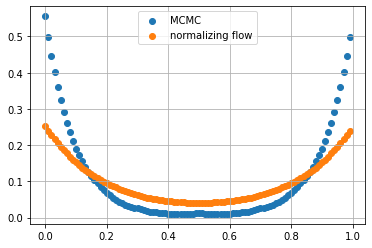

In [142]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

g=g_ur
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(MCMC_list,g)
plt.scatter(NF_list,g_nf)
plt.legend(["MCMC","normalizing flow"])
plt.grid(True)
plt.show()


In [1]:


! du -sh logs






11G	logs


In [ ]:
! rm -rf logs


In [ ]:
def configure_flows(level_size,level_step=1):  # n_flows=8,...,12
    flows=[]
    n_levels=(N_latent-N_nod)//level_step
    
    if N_nod==N_latent:
        level_step=0
    
    dim=N_latent//2
    
    for i in range(n_levels):
        for k in range(level_size):
            flows.append(AffineCouplingLayer(configure_theta(dim,dim),split=pair_SplitFunc,swap=k%2))
        flows.append(nn.Linear(dim,dim-level_step//2))    
        dim-=level_step//2    
    
    if dim!=N_nod//2:
        print("smth wrong")
        
    for k in range(level_size):
        flows.append(AffineCouplingLayer(configure_theta(dim,dim),split=pair_SplitFunc,swap=k%2))
    flows = nn.ModuleList(flows)
    
    return flows 

In [11]:
print("start")
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 16,  #2 to 6
                hidden_dim = 2*N_nod , #100-1024
                num_params = 2,
                p_drop=0.4,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    
    flows.append(D(N_nod))
    
    for k in range(n_flows//4):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
        flows.append(L1(N_nod))
    
    for k in range(3 * n_flows//4):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
    
    flows.append(D(N_nod))    
    flows = nn.ModuleList(flows)
    return flows 

def configure_conv_flows(n_conv,kernel_size=3):
    conv_flows=[]
    for i in range(n_conv):
        conv_flows.append(AffineCouplingLayer(Conv_NN(N_nod//2,2,kernel_size),split=pair_SplitFunc,swap=i%2))
    conv_flows = nn.ModuleList(conv_flows)
    return conv_flows

print(normal_dist)

                  

start
Normal(loc: torch.Size([100]), scale: torch.Size([100]))
